In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [3]:
import sys
sys.path.insert(0, '/home/hushengchun/python_library/TransformerLens/')
from argparse import ArgumentParser
from functools import partial 
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm

from eap.graph import Graph
from eap.attribute import attribute
from eap.evaluate import evaluate_graph, evaluate_baseline

from dataset import EAPDataset
from metrics import get_metric

In [4]:
from transformers import AutoModelForCausalLM

In [5]:
cache_dir = '/home/xd/.cache/torch/transformers/'
proxies = {'http': '192.168.53.250:10801'}

#model_name = 'EleutherAI/pythia-2.8b'
model_name = 'gpt2'
device = 0

model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir, proxies=proxies,
    local_files_only=False, low_cpu_mem_usage=True, use_safetensors=False).to(device, dtype=torch.float16)

In huggingface_hub.file_download.cached_download: url = https://huggingface.co/gpt2/resolve/main/pytorch_model.bin
in cached_download: link_path = /home/xd/.cache/torch/transformers/gpt2-pytorch_model.bin
In PreTrainedModel.from_pretrained: resolved_archive_file, filename = /home/xd/.cache/torch/transformers/gpt2-pytorch_model.bin pytorch_model.bin
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/gpt2/resolve/main/generation_config.json
in cached_download: link_path = /home/xd/.cache/torch/transformers/generation_config.json


In [6]:
model = HookedTransformer.from_pretrained(model_name,center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device='cuda',
    hf_model=model,
)

Loaded pretrained model gpt2 into HookedTransformer


In [7]:
task = 'ioi'

In [8]:
model.cfg.use_split_qkv_input = True
model.cfg.use_attn_result = True
model.cfg.use_hook_mlp_in = True
task_metric_name = 'logit_diff'
ds = EAPDataset(task, model_name)
batch_size = 10
dataloader = ds.to_dataloader(batch_size)
task_metric = get_metric(task_metric_name, task, model=model)

In [9]:
import time

In [10]:
model_name_noslash = model_name.split('/')[-1]

T1 = time.time()
g2 = Graph.from_model(model)
attribute(model, g2, dataloader, partial(task_metric, mean=True, loss=True), method='EAP-IG', ig_steps=5)

T2 = time.time()

print('运行时间：%s s' %(T2 - T1))

  0%|          | 0/100 [00:00<?, ?it/s]

s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([143, 1]) blocks.10.hook_mlp_in
s:  torch.Size([143])
score:  torch.Size([143])
s:  torch.Size([131, 12]) blocks.10.hook_v_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_k_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_q_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([130, 1]) blocks.9.hook_mlp_in
s:  torch.Size([130])
score:  torch

  1%|          | 1/100 [00:01<02:03,  1.25s/it]

s:  torch.Size([66, 12]) blocks.5.hook_v_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([66, 12]) blocks.5.hook_k_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([66, 12]) blocks.5.hook_q_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([65, 1]) blocks.4.hook_mlp_in
s:  torch.Size([65])
score:  torch.Size([65])
s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.

  2%|▏         | 2/100 [00:02<01:51,  1.13s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

  3%|▎         | 3/100 [00:03<01:46,  1.10s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

  4%|▍         | 4/100 [00:04<01:43,  1.08s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

  5%|▌         | 5/100 [00:05<01:41,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

  6%|▌         | 6/100 [00:06<01:40,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

  7%|▋         | 7/100 [00:07<01:39,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

  8%|▊         | 8/100 [00:08<01:38,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

  9%|▉         | 9/100 [00:09<01:36,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 10%|█         | 10/100 [00:10<01:35,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 11%|█         | 11/100 [00:11<01:33,  1.05s/it]

s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch

 12%|█▏        | 12/100 [00:12<01:30,  1.03s/it]

s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch

 13%|█▎        | 13/100 [00:13<01:28,  1.02s/it]

s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch

 14%|█▍        | 14/100 [00:14<01:28,  1.03s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 15%|█▌        | 15/100 [00:15<01:28,  1.04s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 16%|█▌        | 16/100 [00:16<01:27,  1.04s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 17%|█▋        | 17/100 [00:18<01:26,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 18%|█▊        | 18/100 [00:19<01:26,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 19%|█▉        | 19/100 [00:20<01:25,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 20%|██        | 20/100 [00:21<01:24,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 21%|██        | 21/100 [00:22<01:22,  1.04s/it]

s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([143, 1]) blocks.10.hook_mlp_in
s:  torch.Size([143])
score:  torch.Size([143])
s:  torch.S

 22%|██▏       | 22/100 [00:23<01:21,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 23%|██▎       | 23/100 [00:24<01:19,  1.03s/it]

s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  t

 24%|██▍       | 24/100 [00:25<01:19,  1.04s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 25%|██▌       | 25/100 [00:26<01:18,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 26%|██▌       | 26/100 [00:27<01:16,  1.03s/it]

s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([143, 1]) blocks.10.hook_mlp_in
s:  torch.Size([143])
score:  torch.Size([143])
s:  torch.S

 27%|██▋       | 27/100 [00:28<01:15,  1.04s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 28%|██▊       | 28/100 [00:29<01:15,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 29%|██▉       | 29/100 [00:30<01:14,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 30%|███       | 30/100 [00:31<01:12,  1.04s/it]

s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch

 31%|███       | 31/100 [00:32<01:12,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 32%|███▏      | 32/100 [00:33<01:09,  1.02s/it]

s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([143, 1]) blocks.10.hook_mlp_in
s:  torch.Size([143])
score:  torch.Size([143])
s:  torch.Size([131, 12]) blocks.10.hook_v_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_k_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_q_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([130, 1]) blocks.9.hook_mlp_in
s:  torch.Size([130])
score:  torch

 33%|███▎      | 33/100 [00:34<01:09,  1.03s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 34%|███▍      | 34/100 [00:35<01:07,  1.02s/it]

s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch

 35%|███▌      | 35/100 [00:36<01:07,  1.03s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 36%|███▌      | 36/100 [00:37<01:06,  1.04s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 37%|███▋      | 37/100 [00:38<01:06,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 38%|███▊      | 38/100 [00:39<01:05,  1.05s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 39%|███▉      | 39/100 [00:40<01:04,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 40%|████      | 40/100 [00:42<01:03,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 41%|████      | 41/100 [00:43<01:02,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 42%|████▏     | 42/100 [00:44<01:01,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 43%|████▎     | 43/100 [00:45<01:00,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 44%|████▍     | 44/100 [00:46<00:59,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 45%|████▌     | 45/100 [00:47<00:58,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 46%|████▌     | 46/100 [00:48<00:57,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 47%|████▋     | 47/100 [00:49<00:56,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 48%|████▊     | 48/100 [00:50<00:55,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 49%|████▉     | 49/100 [00:51<00:54,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 50%|█████     | 50/100 [00:52<00:53,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 51%|█████     | 51/100 [00:53<00:52,  1.06s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 52%|█████▏    | 52/100 [00:54<00:51,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 53%|█████▎    | 53/100 [00:55<00:50,  1.07s/it]

s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.

 54%|█████▍    | 54/100 [00:56<00:48,  1.05s/it]

s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Siz

 55%|█████▌    | 55/100 [00:57<00:47,  1.05s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 56%|█████▌    | 56/100 [00:59<00:46,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 57%|█████▋    | 57/100 [01:00<00:45,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 58%|█████▊    | 58/100 [01:01<00:43,  1.03s/it]

s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([143, 1]) blocks.10.hook_mlp_in
s:  torch.Size([143])
score:  torch.Size([143])
s:  torch.Size([131, 12]) blocks.10.hook_v_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_k_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_q_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([130, 1]) blocks.9.hook_mlp_in
s:  torch.Size([130])
score:  torch

 59%|█████▉    | 59/100 [01:02<00:42,  1.04s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 60%|██████    | 60/100 [01:03<00:42,  1.05s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 61%|██████    | 61/100 [01:04<00:43,  1.12s/it]

s:  torch.Size([78, 1]) blocks.5.hook_mlp_in
s:  torch.Size([78])
score:  torch.Size([78])
s:  torch.Size([66, 12]) blocks.5.hook_v_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([66, 12]) blocks.5.hook_k_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([66, 12]) blocks.5.hook_q_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([65, 1]) blocks.4.hook_mlp_in
s:  torch.Size([65])
score:  torch.Size([65])
s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 

 62%|██████▏   | 62/100 [01:05<00:42,  1.11s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 63%|██████▎   | 63/100 [01:06<00:40,  1.10s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 64%|██████▍   | 64/100 [01:07<00:39,  1.09s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 65%|██████▌   | 65/100 [01:08<00:37,  1.08s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 66%|██████▌   | 66/100 [01:09<00:36,  1.08s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 67%|██████▋   | 67/100 [01:10<00:35,  1.08s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 68%|██████▊   | 68/100 [01:11<00:32,  1.02s/it]

s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_q_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([26, 1]) blocks.1.hook_mlp_in
s:  torch.Size([26])
score:  torch.Size([26])
s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12])

 69%|██████▉   | 69/100 [01:12<00:32,  1.04s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 70%|███████   | 70/100 [01:13<00:31,  1.05s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 71%|███████   | 71/100 [01:15<00:30,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 72%|███████▏  | 72/100 [01:16<00:29,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 73%|███████▎  | 73/100 [01:17<00:28,  1.07s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 74%|███████▍  | 74/100 [01:18<00:26,  1.04s/it]

s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([143, 1]) blocks.10.hook_mlp_in
s:  torch.Size([143])
score:  torch.Size([143])
s:  torch.Size([131, 12]) blocks.10.hook_v_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_k_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_q_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([130, 1]) blocks.9.hook_mlp_in
s:  torch.Size([130])
score:  torch

 75%|███████▌  | 75/100 [01:19<00:26,  1.05s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 76%|███████▌  | 76/100 [01:20<00:25,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 77%|███████▋  | 77/100 [01:21<00:24,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 78%|███████▊  | 78/100 [01:22<00:23,  1.05s/it]

s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Siz

 79%|███████▉  | 79/100 [01:23<00:22,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 80%|████████  | 80/100 [01:24<00:21,  1.06s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 81%|████████  | 81/100 [01:25<00:20,  1.07s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 82%|████████▏ | 82/100 [01:26<00:18,  1.05s/it]

s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Siz

 83%|████████▎ | 83/100 [01:27<00:17,  1.04s/it]

s:  torch.Size([14, 12]) blocks.1.hook_v_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_k_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([14, 12]) blocks.1.hook_q_input
s:  torch.Size([14, 12])
score:  torch.Size([14, 12])
s:  torch.Size([13, 1]) blocks.0.hook_mlp_in
s:  torch.Size([13])
score:  torch.Size([13])
s:  torch.Size([1, 12]) blocks.0.hook_v_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_k_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([1, 12]) blocks.0.hook_q_input
s:  torch.Size([1, 12])
score:  torch.Size([1, 12])
s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Siz

 84%|████████▍ | 84/100 [01:28<00:16,  1.05s/it]

s:  torch.Size([66, 12]) blocks.5.hook_k_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([66, 12]) blocks.5.hook_q_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([65, 1]) blocks.4.hook_mlp_in
s:  torch.Size([65])
score:  torch.Size([65])
s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.

 85%|████████▌ | 85/100 [01:29<00:15,  1.06s/it]

s:  torch.Size([65, 1]) blocks.4.hook_mlp_in
s:  torch.Size([65])
score:  torch.Size([65])
s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 

 86%|████████▌ | 86/100 [01:30<00:14,  1.07s/it]

s:  torch.Size([66, 12]) blocks.5.hook_k_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([66, 12]) blocks.5.hook_q_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([65, 1]) blocks.4.hook_mlp_in
s:  torch.Size([65])
score:  torch.Size([65])
s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.

 87%|████████▋ | 87/100 [01:31<00:13,  1.07s/it]

s:  torch.Size([66, 12]) blocks.5.hook_q_input
s:  torch.Size([66, 12])
score:  torch.Size([66, 12])
s:  torch.Size([65, 1]) blocks.4.hook_mlp_in
s:  torch.Size([65])
score:  torch.Size([65])
s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 

 88%|████████▊ | 88/100 [01:33<00:12,  1.07s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 89%|████████▉ | 89/100 [01:34<00:11,  1.08s/it]

s:  torch.Size([53, 12]) blocks.4.hook_v_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_k_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([53, 12]) blocks.4.hook_q_input
s:  torch.Size([53, 12])
score:  torch.Size([53, 12])
s:  torch.Size([52, 1]) blocks.3.hook_mlp_in
s:  torch.Size([52])
score:  torch.Size([52])
s:  torch.Size([40, 12]) blocks.3.hook_v_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_k_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([40, 12]) blocks.3.hook_q_input
s:  torch.Size([40, 12])
score:  torch.Size([40, 12])
s:  torch.Size([39, 1]) blocks.2.hook_mlp_in
s:  torch.Size([39])
score:  torch.Size([39])
s:  torch.Size([27, 12]) blocks.2.hook_v_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.Size([27, 12]) blocks.2.hook_k_input
s:  torch.Size([27, 12])
score:  torch.Size([27, 12])
s:  torch.

 89%|████████▉ | 89/100 [01:34<00:11,  1.06s/it]

s:  torch.Size([157, 1]) blocks.11.hook_resid_post
s:  torch.Size([157])
score:  torch.Size([157])
s:  torch.Size([156, 1]) blocks.11.hook_mlp_in
s:  torch.Size([156])
score:  torch.Size([156])
s:  torch.Size([144, 12]) blocks.11.hook_v_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_k_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([144, 12]) blocks.11.hook_q_input
s:  torch.Size([144, 12])
score:  torch.Size([144, 12])
s:  torch.Size([143, 1]) blocks.10.hook_mlp_in
s:  torch.Size([143])
score:  torch.Size([143])
s:  torch.Size([131, 12]) blocks.10.hook_v_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_k_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([131, 12]) blocks.10.hook_q_input
s:  torch.Size([131, 12])
score:  torch.Size([131, 12])
s:  torch.Size([130, 1]) blocks.9.hook_mlp_in
s:  torch.Size([130])
score:  torch

KeyboardInterrupt: 

In [ ]:
g2.apply_greedy(600)
g2.prune_dead_nodes()
gs2 = g2.to_graphviz()
gs2.draw(f'gpt2-ioi.png', prog='dot')

In [25]:
baseline = evaluate_baseline(model, dataloader, partial(task_metric, mean=False, loss=False)).mean().item()
corrupted_baseline = evaluate_baseline(model, dataloader, partial(task_metric, mean=False, loss=False), run_corrupted=True).mean().item()

100%|██████████| 50/50 [00:03<00:00, 15.85it/s]


In [26]:
baseline

8.40956974029541

In [27]:
n_edges = []
results = []
steps = list(range(0, 2001, 100))
with tqdm(total=len(steps)) as pbar:
    for i in steps:
        n_edge = []
        result = []
        g2.apply_greedy(i, absolute=True)
        g2.prune_dead_nodes(prune_childless=True, prune_parentless=True)
        n = g2.count_included_edges()
        r = evaluate_graph(model, g2, dataloader, partial(task_metric, mean=False, loss=False), quiet=True)
        n_edge.append(n)
        result.append(r.mean().item())
        pbar.update(1)
        n_edges.append(n_edge)
        results.append(result)

n_edges = np.array(n_edges)
results = np.array(results)

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|▍         | 1/21 [00:01<00:39,  1.98s/it]

True

 10%|▉         | 2/21 [00:05<00:59,  3.15s/it]

True

 14%|█▍        | 3/21 [00:10<01:04,  3.57s/it]

True

 19%|█▉        | 4/21 [00:14<01:06,  3.92s/it]

True

 24%|██▍       | 5/21 [00:18<01:03,  3.98s/it]

True

 29%|██▊       | 6/21 [00:22<01:00,  4.04s/it]

True

 33%|███▎      | 7/21 [00:26<00:57,  4.07s/it]

True

 38%|███▊      | 8/21 [00:31<00:53,  4.09s/it]

True

 43%|████▎     | 9/21 [00:35<00:49,  4.11s/it]

True

 48%|████▊     | 10/21 [00:39<00:45,  4.12s/it]

True

 52%|█████▏    | 11/21 [00:43<00:41,  4.13s/it]

True

 57%|█████▋    | 12/21 [00:47<00:37,  4.14s/it]

True

 62%|██████▏   | 13/21 [00:51<00:33,  4.14s/it]

True

 67%|██████▋   | 14/21 [00:55<00:29,  4.15s/it]

True

 71%|███████▏  | 15/21 [01:00<00:24,  4.16s/it]

True

 76%|███████▌  | 16/21 [01:04<00:20,  4.16s/it]

True

 81%|████████  | 17/21 [01:08<00:16,  4.17s/it]

True

 86%|████████▌ | 18/21 [01:12<00:12,  4.17s/it]

True

 90%|█████████ | 19/21 [01:16<00:08,  4.17s/it]

True

 95%|█████████▌| 20/21 [01:21<00:04,  4.18s/it]

True

100%|██████████| 21/21 [01:25<00:00,  4.18s/it]

True

100%|██████████| 21/21 [01:25<00:00,  4.06s/it]


In [28]:
d = {'baseline':[baseline] * len(steps), 
     'corrupted_baseline':[corrupted_baseline] * len(steps),
     'edges': steps}

labels = ['EAP-IG']
for i, label in enumerate(labels):
    d[f'edges_{label}'] = n_edges[:, i].tolist()
    d[f'loss_{label}'] = results[:, i].tolist()
df = pd.DataFrame.from_dict(d)
Path(f'results/pareto/{model_name_noslash}/csv').mkdir(exist_ok=True, parents=True)
df.to_csv(f'results/pareto/{model_name_noslash}/csv/{task}_3.csv', index=False)

Text(0.5, 1.0, 'IOI')

Text(0.5, 1.0, 'IOI_1')

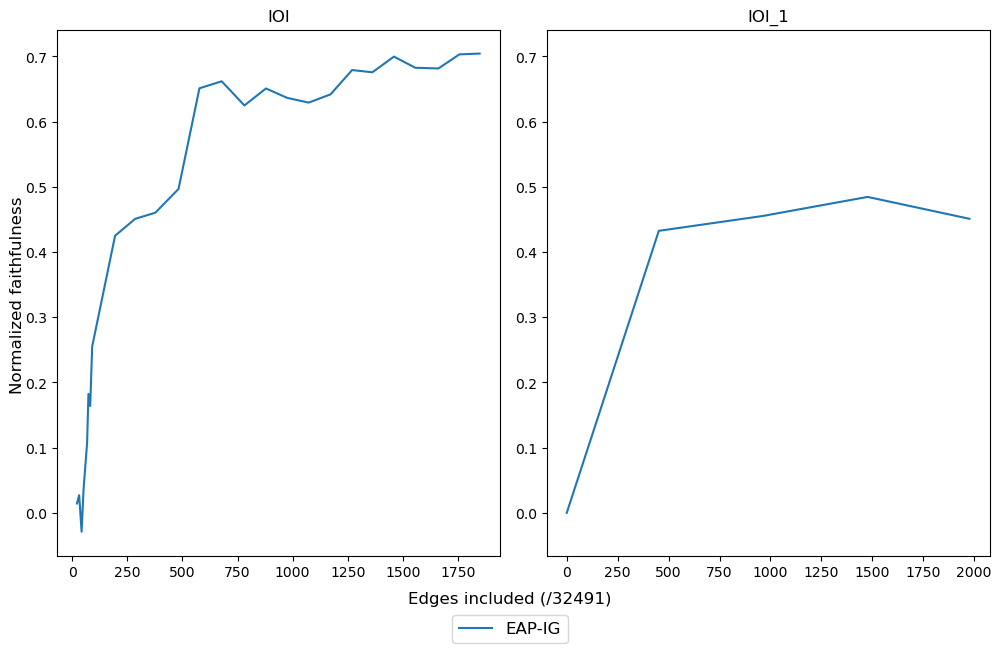

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

display_name_dict = {'ioi': 'IOI', 'ioi_1': 'IOI_1'}
def display_name(task):
    if '-comma' in task:
        task = task[:-6]
    return display_name_dict[task] 

prob_diff_tasks = ['greater-than', 'fact-retrieval', 'sva']
def task_to_metric(task):
    if any(ptask in task for ptask in prob_diff_tasks):
        return 'prob_diff'
    return 'logit_diff'

def n_edges(model):
    if model == 'gpt2':
        return 32491
    elif model == 'gpt2-xl':
        return 2235025
    elif model =='pythia-2.8B':
        return 1591857
    else:
        raise ValueError(f'Bad model: {model}')

model = model_name
task_names = ['ioi', 'ioi_1', 'ioi_3']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6), sharey=True)
for task_name, ax in zip(task_names, axs.flat):
    df = pd.read_csv(f'/home/hushengchun/project/eap-ig-faithfulness/results/pareto/{model}/csv/{task_name}.csv')
    for losstype in ['EAP-IG']:
        df[f'loss_{losstype}'] = (df[f'loss_{losstype}'] - df['corrupted_baseline']) /(df['baseline'] - df['corrupted_baseline'])
    
    ax.plot(df['edges_EAP-IG'], df['loss_EAP-IG'], label='EAP-IG')
    
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.set_title(f'{display_name(task_name)}')
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=4, fontsize=12)
xlabel = fig.text(0.5, -0.015, f'Edges included (/{n_edges(model)})', ha='center', fontsize=12)
ylabel = fig.text(-0.00, 0.5, 'Normalized faithfulness', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()
fig.show()

In [12]:
dataloader = tqdm(dataloader)
dataloader = list(dataloader)

100%|██████████| 5/5 [00:00<00:00, 520.66it/s]


In [13]:
layer, head = [(4, 11)][0]

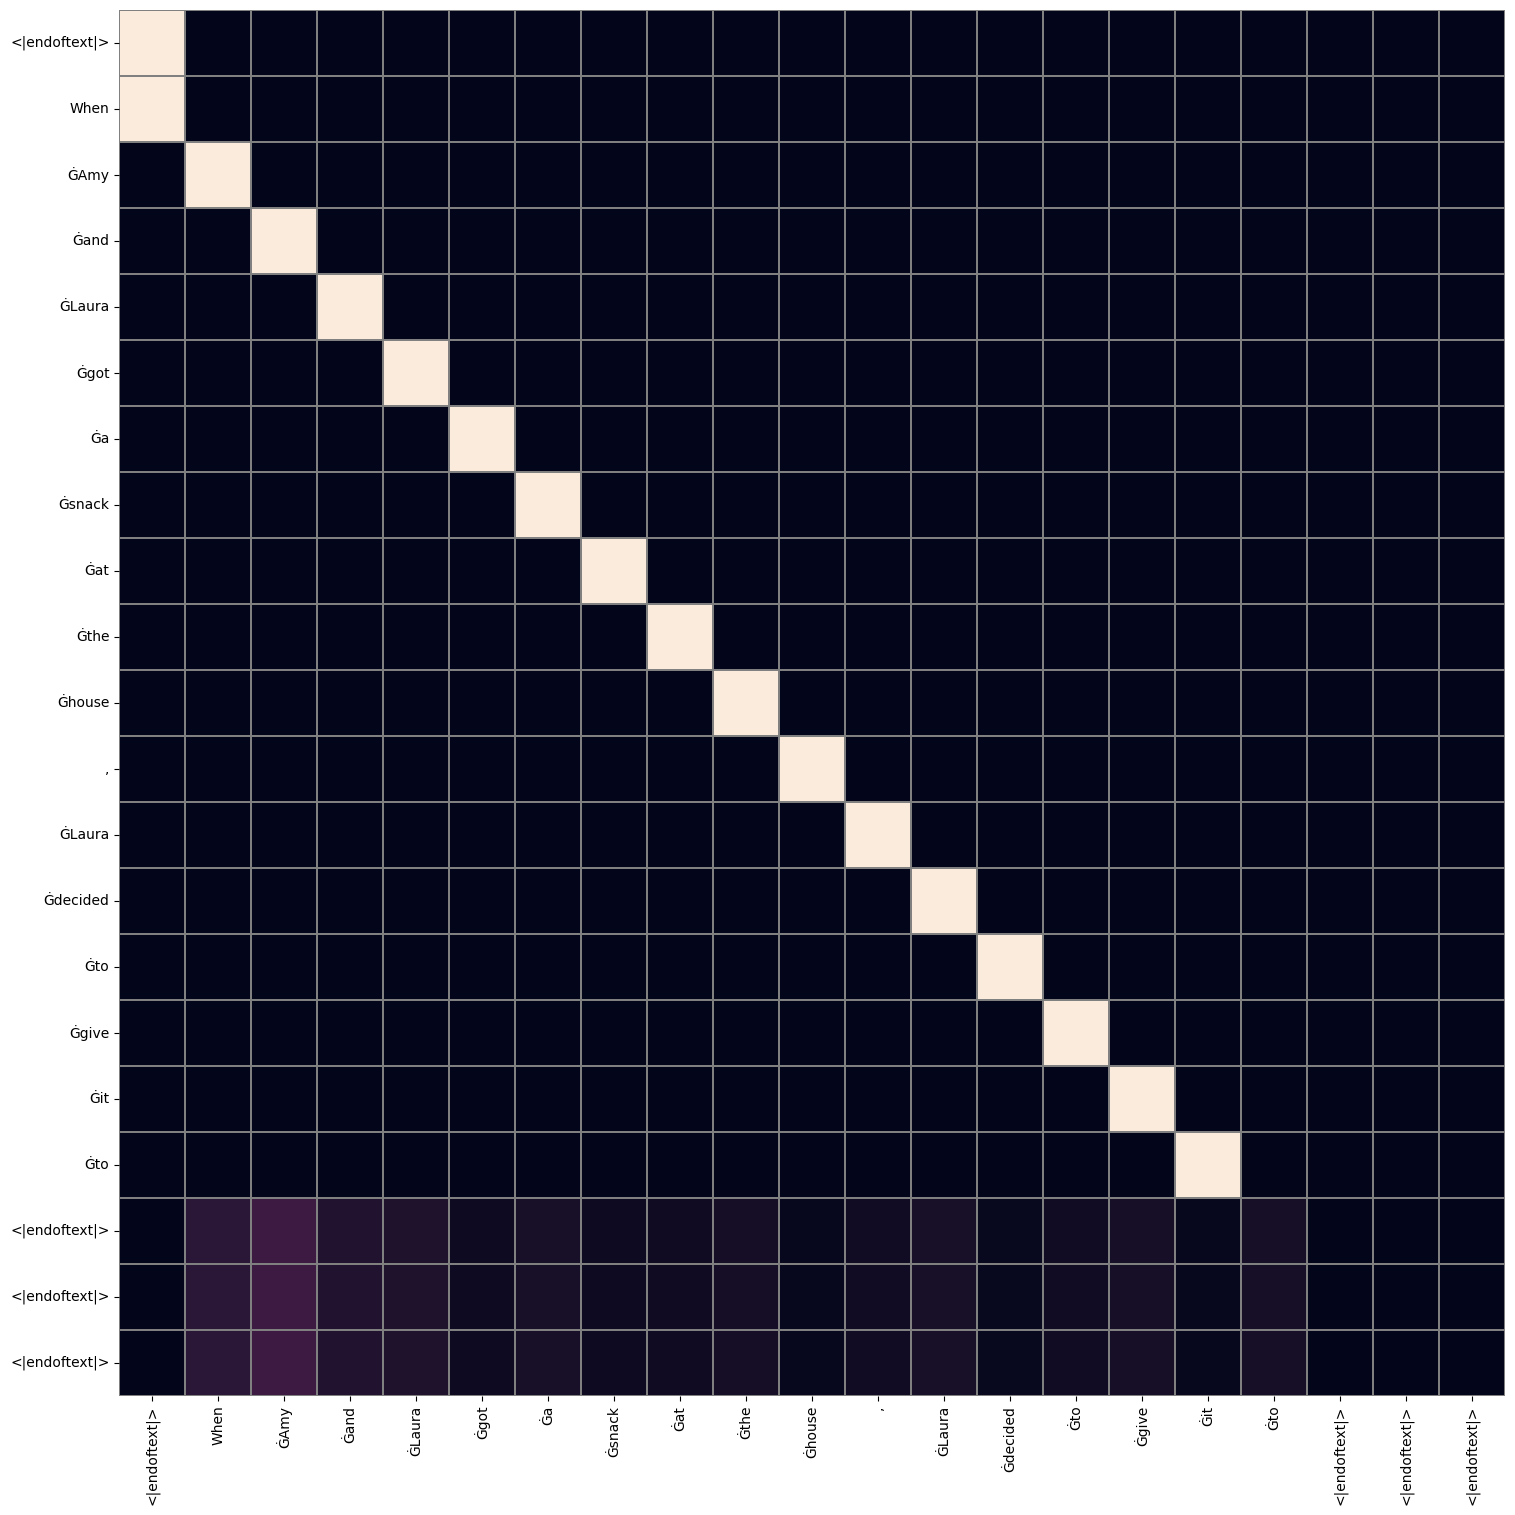

In [14]:
from eap.attribute import tokenize_plus, _plot_attn
for clean, corrupt, label in dataloader[0:1]:
    # tokens_ids = model.to_tokens(clean, prepend_bos=True, padding_side='right')
    token_ids, attention_mask, input_lengths, n_pos = tokenize_plus(model, clean)
    clean_logits, cache = model.run_with_cache(token_ids, attention_mask = attention_mask)
    tokens = model.tokenizer.convert_ids_to_tokens(token_ids[0])
    attn = cache[f'blocks.{layer}.attn.hook_pattern'][0][head]
    _plot_attn(attn, tokens, figsize=(18, 18))

In [9]:
baselines = evaluate_baseline(model, dataloader, partial(task_metric, mean=False, loss=False)).mean(-1)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 15.16it/s]


In [10]:
g = Graph.from_model(model)

In [ ]:
for edge_name, edge in tqdm(list(g.edges.items())):
    edge.in_graph = False
    performances = evaluate_graph(model, g, dataloader, partial(task_metric, mean=False, loss=False), quiet=True).mean(-1)
    differences = performances - baselines
    g.edges[edge_name].score = differences
    edge.in_graph = True

100%|██████████| 32491/32491 [6:38:17<00:00,  1.36it/s]  


In [12]:
json_file = "/home/hushengchun/project/eap-ig-faithfulness/gpt2-ioi.json"

In [13]:
g.to_json(json_file)

In [17]:
g.apply_greedy(600)
g.prune_dead_nodes()
gs2 = g.to_graphviz()
gs2.draw(f'gpt2-ioi-ap.png', prog='dot')

In [10]:
metric_names = ['logit_diff', 'prob_diff', 'kl', 'js']
metrics = [partial(get_metric(metric_name, task, model=model), mean=False, loss=False) for metric_name in metric_names]

In [11]:
gs = [Graph.from_model(model) for _ in metrics]

In [14]:
for edge_name, edge in tqdm(list(gs[0].edges.items())):
    edge.in_graph = False
    performances = torch.stack(evaluate_graph(model, gs[0], dataloader_patching, metrics, quiet=True)).mean(-1)
    differences = (performances - baselines).tolist()
    for g, diff in zip(gs, differences):
        g.edges[edge_name].score = diff
    edge.in_graph = True

100%|██████████| 32491/32491 [7:03:12<00:00,  1.28it/s]   


In [10]:
json_file = "/home/hushengchun/project/eap-ig-faithfulness/gpt2-ioi-2.json"

In [11]:
g = Graph.from_json(json_file)

In [14]:
baselines = evaluate_baseline(model, dataloader, partial(task_metric, mean=False, loss=False)).mean().item()
corrupted_baseline = evaluate_baseline(model, dataloader, partial(task_metric, mean=False, loss=False), run_corrupted=True).mean().item()

100%|██████████| 5/5 [00:00<00:00, 18.23it/s]
